In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for c in columns:
   print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for c in columns:
   print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

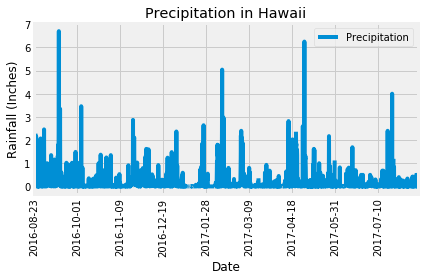

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_scores = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_scores, columns=['date', 'precipitation'])

# Reset index
rain_df.set_index(rain_df['date'], inplace=True)

# Show df head
rain_df.head(5)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot()

# Add title, labels, legend and ticks
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Precipitation'])
plt.xticks(rotation = '90')
plt.tight_layout()

# Save figure
plt.savefig("Images/Precipitation_Hawaii.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
   order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

temp_ranges = session.query(*temperatures).filter(Measurement.station=='USC00519281').all()

temp_ranges


[(54.0, 85.0, 71.66378066378067)]

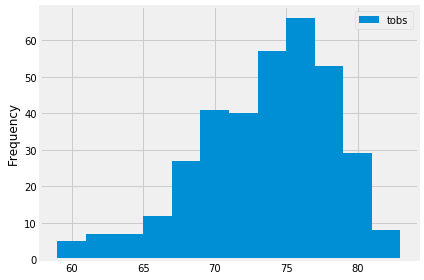

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_frequency = session.query(Measurement.tobs).\
                               filter(Measurement.station=='USC00519281').\
                               filter(Measurement.date >= year_ago).\
                               order_by(Measurement.date.desc()).all()

histogram = pd.DataFrame(temp_frequency, columns=['tobs'])
histogram.plot.hist(bins=12)
plt.tight_layout()

# Save figure
plt.savefig("Images/12_Months_Temp.png")

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip use data from 3 years ago for those same dates.
arrival = dt.date(2020, 7, 1)
departure = dt.date(2020, 7, 16)
three_years_ago = dt.timedelta(days=1095)
arrival_three_years = arrival - three_years_ago
departure_three_years = departure - three_years_ago

tmin, tavg, tmax = calc_temps(arrival_three_years.strftime("%Y-%m-%d"), departure_three_years.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)


69.0 78.27 87.0


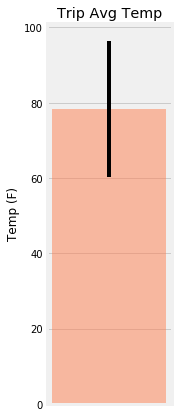

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Define Y Error Bar and X

yerr = tmax - tmin

# Set Plot
fig, ax = plt.subplots(figsize= (2, 7))

# Set title, ticks and lables 
ax.bar(1, tavg, yerr=yerr, alpha= 0.5, color='coral')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')

# Show plot
plt.show()

# Save figure
plt.savefig("Images/Trip_Avg_Temp.png")

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
arrival = dt.date(2020, 7, 1)
departure = dt.date(2020, 7, 16)

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= arrival_three_years).\
            filter(Measurement.date <= departure_three_years).group_by(Station.name).order_by(func.sum(Measurement.prcp).\
            desc()).all()

print(rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.6600000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.87), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.9600000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.67), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.24), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.13), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
